In [8]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import resample_poly
import pandas as pd
import IPython.display as ipd
import time

AUDIO FILE INFORMATION:
----------------------------------------------------------------------
Sample Rate: 44100 Hz
Duration: 15.05 seconds
Total Samples: 663599
Audio Shape: (663599,)

Original Train Audio:


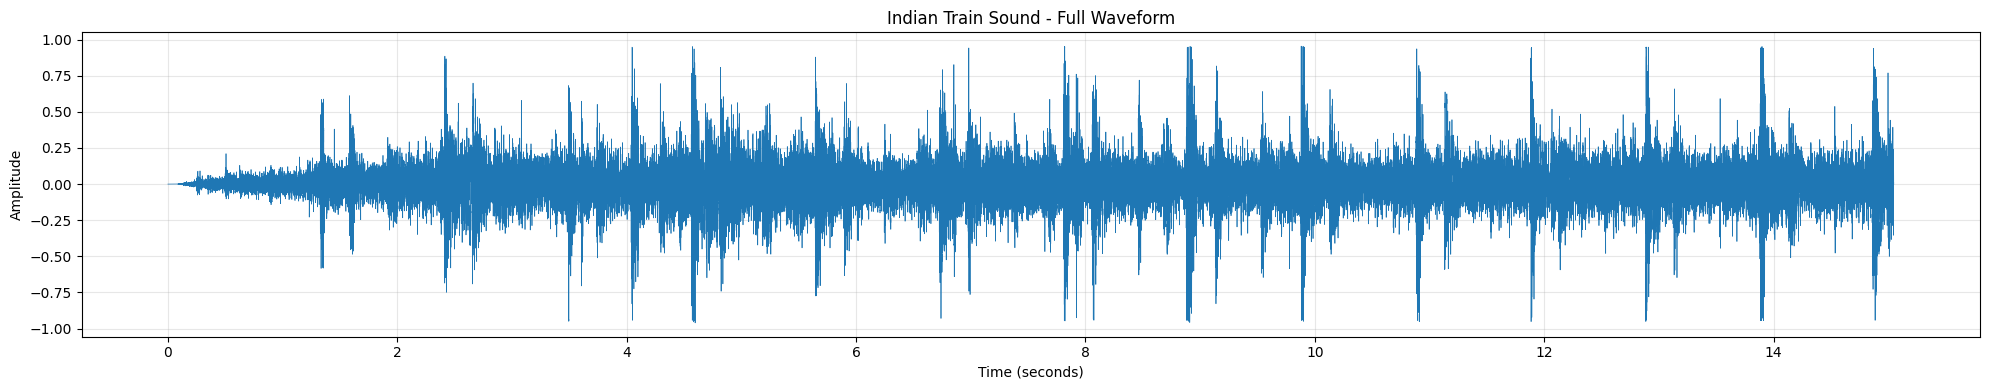

In [9]:
train_path = 'data/indian_train_sounds.mp3'
y_train, sr_train = librosa.load(train_path, sr=None)

print("AUDIO FILE INFORMATION:")
print("-" * 70)
print(f"Sample Rate: {sr_train} Hz")
print(f"Duration: {len(y_train)/sr_train:.2f} seconds")
print(f"Total Samples: {len(y_train)}")
print(f"Audio Shape: {y_train.shape}")
print()

# Play the audio
print("Original Train Audio:")
ipd.display(ipd.Audio(y_train, rate=sr_train))

# Visualize the full waveform
time_train = np.linspace(0, len(y_train)/sr_train, len(y_train))

plt.figure(figsize=(20, 4))
plt.plot(time_train, y_train, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Indian Train Sound - Full Waveform')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In this sound bite we have a periodic pattern (click-clack) of wheels over rail joints. It is noisy with many small fluctiations (from engine, wind, background etc.).

Convolution lets me filter or emphasize parts of this sound that matter to my goal.

In [67]:
print("="*70)
print("IMPLEMENTING CONVOLUTION FROM SCRATCH")
print("="*70)
print()

def convolve_1d(signal, kernel, mode='valid'):
    
    # Convert to numpy arrays
    x = np.asarray(signal)
    h = np.asarray(kernel)
    
    N = len(x)  # Signal length
    K = len(h)  # Kernel length
    
    # Determine output length based on mode
    if mode == 'full':
        output_len = N + K - 1
        pad_left = K - 1
        pad_right = K - 1
    elif mode == 'same':
        output_len = N
        pad_left = (K - 1) // 2
        pad_right = K - 1 - pad_left
    elif mode == 'valid':
        output_len = N - K + 1
        pad_left = 0
        pad_right = 0
    else:
        raise ValueError("Mode must be 'valid', 'same', or 'full'")
    
    # output buffer
    y = np.zeros(output_len)
    
    # Padding signal with zeros for boundary handling
    x_padded = np.pad(x, (pad_left, pad_right), mode='constant', constant_values=0)
    
    # Convolution loop
    for n in range(output_len):
        # Sum over all kernel coefficients in h[k]
        for k in range(K):
            y[n] += h[k] * x_padded[n + (K - 1) - k]
    return y


# Test with simple example to verify correctness
print("VERIFICATION TEST:")
print("-" * 70)

# Simple test signal
x_test = np.array([1, 2, 3, 4, 5])
# Simple averaging filter (moving average of 3 samples)
h_test = np.array([1/3, 1/3, 1/3])

# Our implementation
y_func = convolve_1d(x_test, h_test, mode='valid')

# NumPy implementation (reference)
y_numpy = np.convolve(x_test, h_test, mode='valid')

print(f"Input signal: {x_test}")
print(f"Filter kernel: {h_test}")
print(f"Implementation result: {y_func}")
print(f"NumPy result: {y_numpy}")
print(f"Difference: {np.abs(y_func - y_numpy)}")
print(f"Max error: {np.max(np.abs(y_func - y_numpy)):.10f}")

IMPLEMENTING CONVOLUTION FROM SCRATCH

VERIFICATION TEST:
----------------------------------------------------------------------
Input signal: [1 2 3 4 5]
Filter kernel: [0.33333333 0.33333333 0.33333333]
Implementation result: [2. 3. 4.]
NumPy result: [2. 3. 4.]
Difference: [2.22044605e-16 4.44089210e-16 4.44089210e-16]
Max error: 0.0000000000


Sample signal: 0.2s of train horn audio
Sample rate: 44100 Hz
Signal length: 8820 samples

Filter kernel: Moving average, size=51
Effect: Smooths signal by averaging 51 adjacent samples

COMPARISON: Implementation vs NumPy Library
Maximum absolute error: 5.55e-16
Mean absolute error:    2.61e-17
RMS error:              5.18e-17



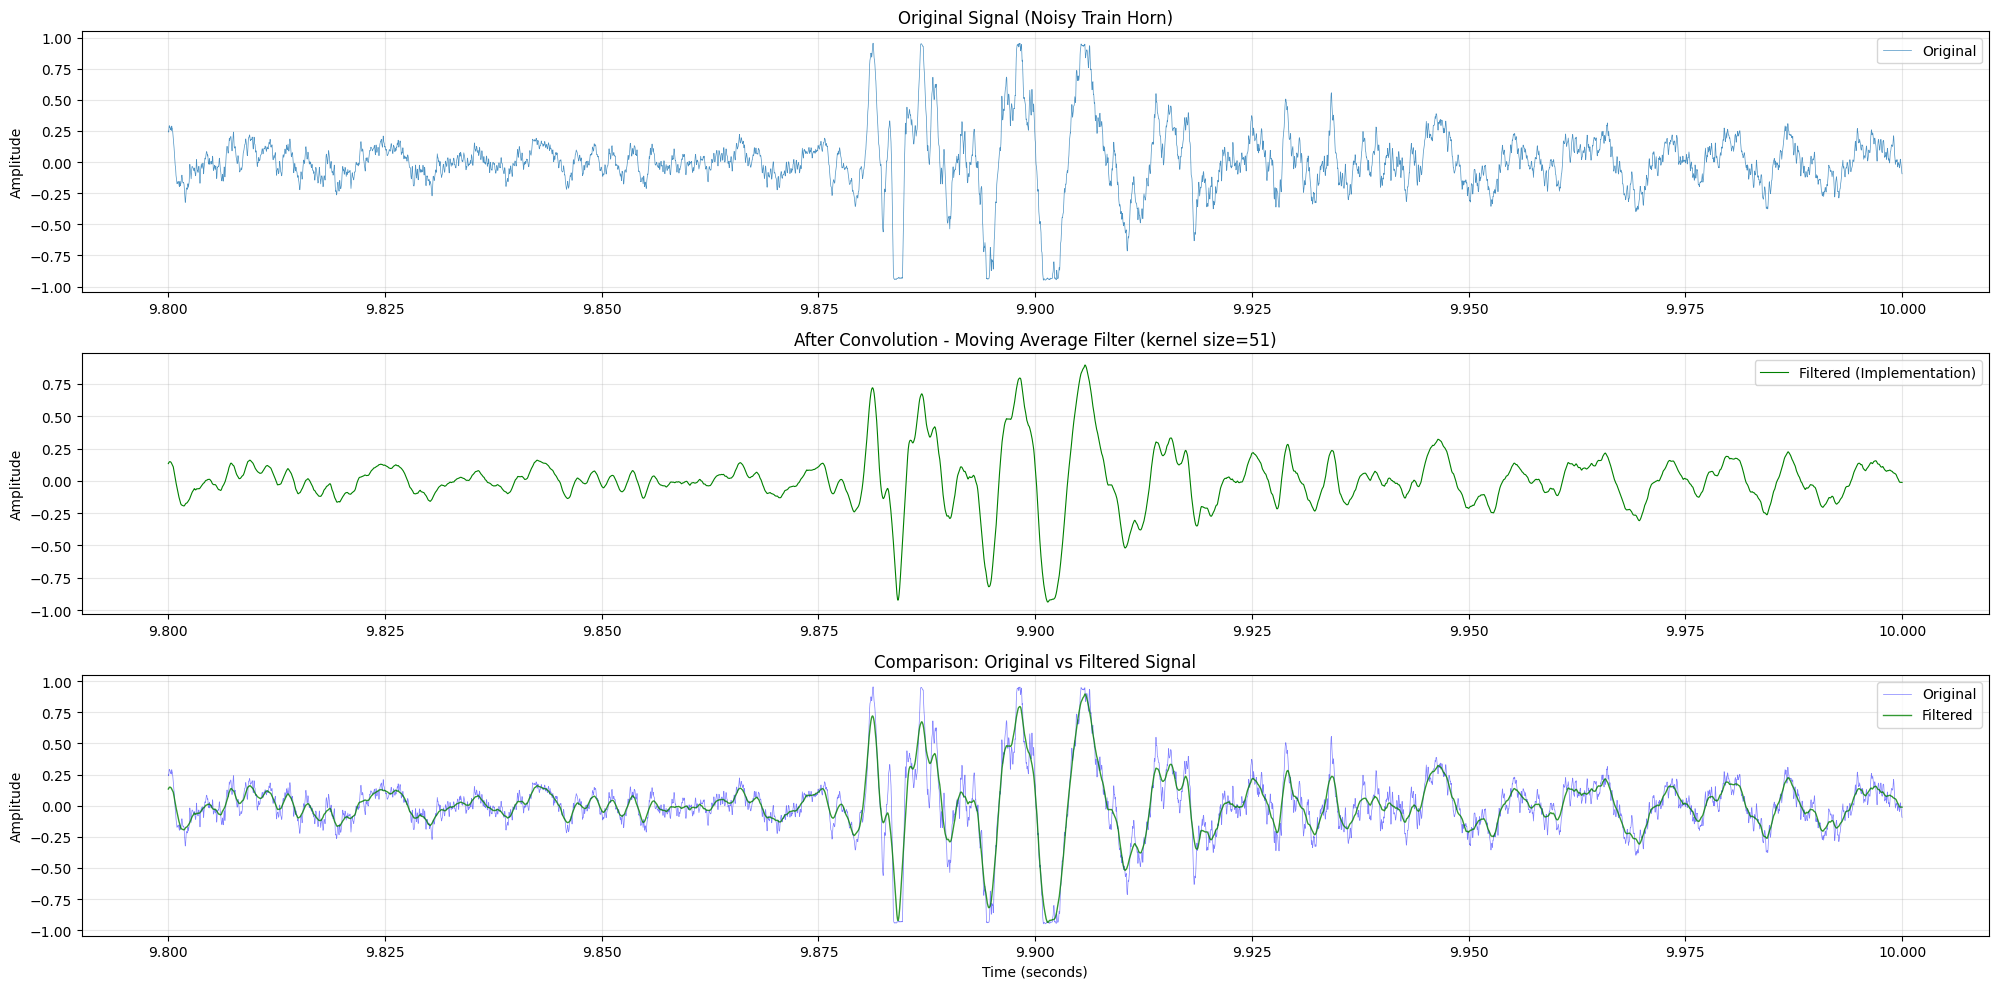

In [78]:
segment_start = 9.8
segment_end = 10
start_idx = int(segment_start * sr_train)
end_idx = int((segment_end) * sr_train)
signal = y_train[start_idx:end_idx]

print(f"Sample signal: 0.2s of train horn audio")
print(f"Sample rate: {sr_train} Hz")
print(f"Signal length: {len(signal)} samples")
print()

# DESIGN FILTER KERNEL: Simple moving average (low-pass filter)
# WHY: Smooths out high-frequency noise while preserving horn shape
kernel_size = 51  # Must be odd for symmetric filter
kernel = np.ones(kernel_size) / kernel_size

print(f"Filter kernel: Moving average, size={kernel_size}")
print(f"Effect: Smooths signal by averaging {kernel_size} adjacent samples")
print()

# Apply implemented convolution
signal_filtered_impl = convolve_1d(signal, kernel, mode='same')

# Apply LIBRARY convolution (for comparison)
signal_filtered_numpy = np.convolve(signal, kernel, mode='same')

# QUANTITATIVE COMPARISON: implementation vs Library
print("="*70)
print("COMPARISON: Implementation vs NumPy Library")
print("="*70)

difference = signal_filtered_impl - signal_filtered_numpy
max_abs_error = np.max(np.abs(difference))
mean_abs_error = np.mean(np.abs(difference))
rms_error = np.sqrt(np.mean(difference ** 2))

print(f"Maximum absolute error: {max_abs_error:.2e}")
print(f"Mean absolute error:    {mean_abs_error:.2e}")
print(f"RMS error:              {rms_error:.2e}")
print()

# Visualize before vs After
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

time_axis = np.linspace(segment_start, segment_end, len(signal))

# Original signal
axes[0].plot(time_axis, signal, linewidth=0.5, alpha=0.8, label='Original')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Original Signal (Noisy Train Horn)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Filtered signal Implementation
axes[1].plot(time_axis, signal_filtered_impl, linewidth=0.8, color='green', label='Filtered (Implementation)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'After Convolution - Moving Average Filter (kernel size={kernel_size})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Overlay comparison
axes[2].plot(time_axis, signal, linewidth=0.5, alpha=0.5, label='Original', color='blue')
axes[2].plot(time_axis, signal_filtered_impl, linewidth=1, alpha=0.8, label='Filtered', color='green')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Amplitude')
axes[2].set_title('Comparison: Original vs Filtered Signal')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Why Choose a Kernel Size of k = 51?

A moving-average kernel size directly controls how much smoothing the filter applies.
The choice of 51 is not arbitrary. It was chosen by experimenting with values and visually evaluation the filtered signal.

After the convolution the filtered signal:
- Has reduced amplitude spikes.
- Shows the dominant periodic structure of the train horn more clearly.
- Noise is significantly reduced.

To compare the implementation vs the numpy solution I used:
- max absolute error, to see the largest difference between my output and NumPy’s output
- mean absolute error, to see the overall deviation between implementations
- RMS error, because it penalizes larger errors more strongly

The Metrics indicate that the implementation was successful.


QUANTITATIVE ANALYSIS - BEFORE VS AFTER CONVOLUTION


METRIC 1: Total Variation (Smoothness)
----------------------------------------------------------------------
Original signal TV:  143.44
Filtered signal TV:  55.48
Reduction:           61.3%

METRIC 2: Peak Amplitude Preservation
----------------------------------------------------------------------
Original peak:  0.9545
Filtered peak:  0.9425
Preservation:   98.7%

METRIC 3: RMS Energy Preservation
----------------------------------------------------------------------
Original RMS:  0.2538
Filtered RMS:  0.2437
Preservation:  96.0%

METRIC 4: High-Frequency Attenuation (>5 kHz)
----------------------------------------------------------------------
Original HF energy:  6.15e+03
Filtered HF energy:  9.38e+01
Attenuation:         98.5%

PARAMETER SPACE EXPLORATION

EXPLORING: Moving average kernel size (filter strength)
----------------------------------------------------------------------



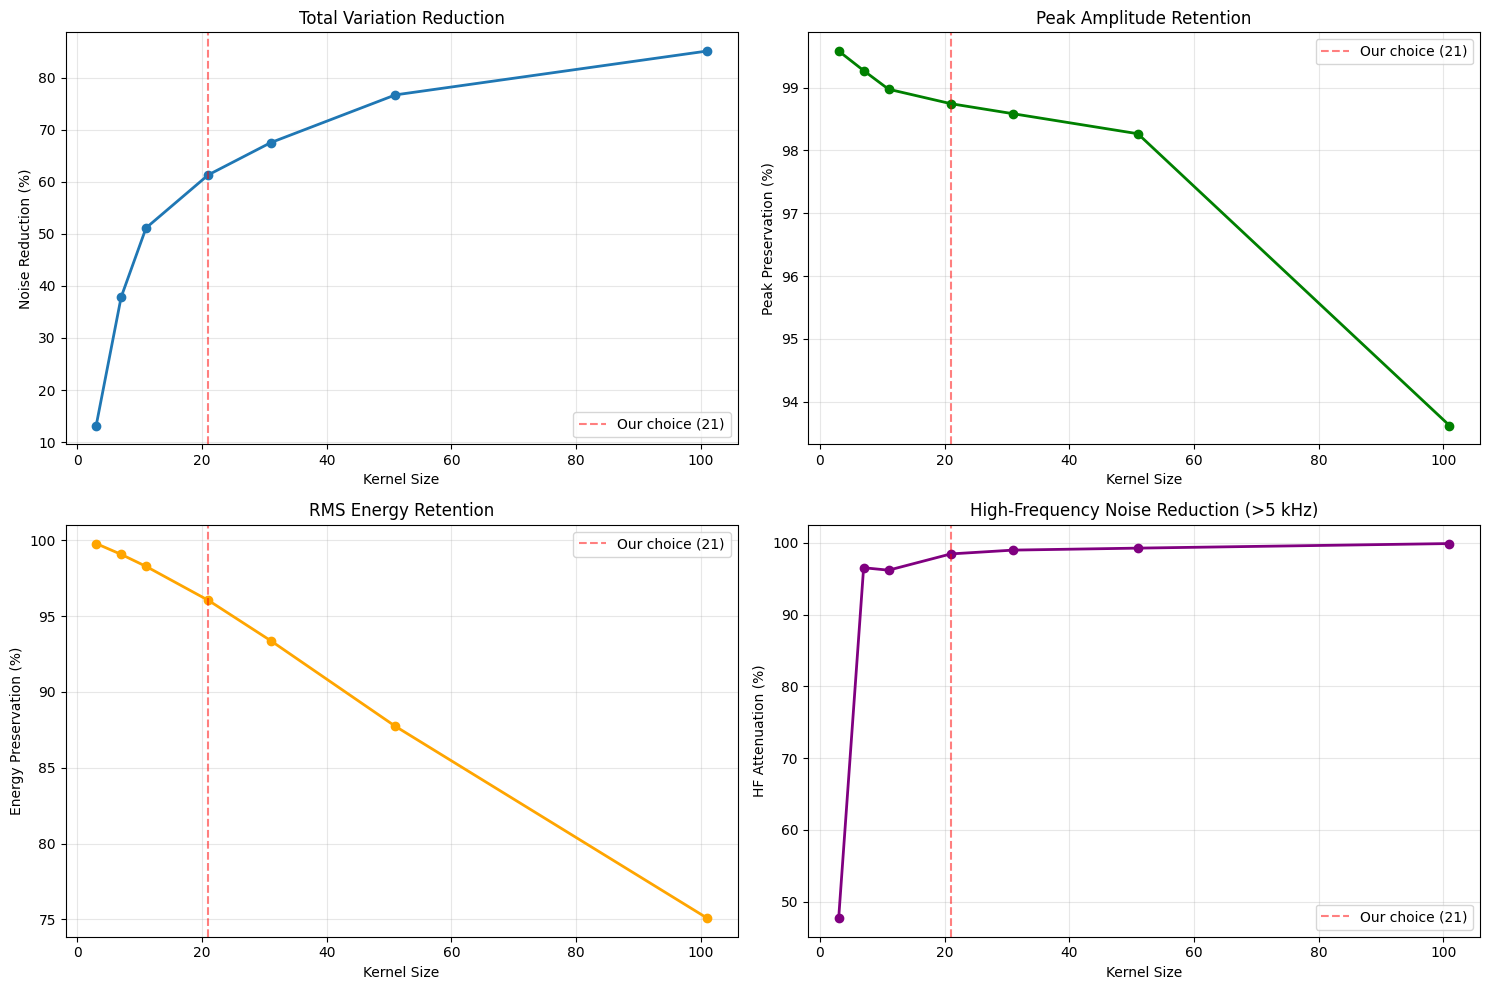

PARAMETER EXPLORATION RESULTS:
----------------------------------------------------------------------
Kernel=  3: Noise= 13.2%, Peak= 99.6%, Energy= 99.8%, HF= 47.7%
Kernel=  7: Noise= 37.8%, Peak= 99.3%, Energy= 99.1%, HF= 96.5%
Kernel= 11: Noise= 51.1%, Peak= 99.0%, Energy= 98.3%, HF= 96.2%
Kernel= 21: Noise= 61.3%, Peak= 98.7%, Energy= 96.0%, HF= 98.5%
Kernel= 31: Noise= 67.5%, Peak= 98.6%, Energy= 93.4%, HF= 99.0%
Kernel= 51: Noise= 76.7%, Peak= 98.3%, Energy= 87.7%, HF= 99.3%
Kernel=101: Noise= 85.1%, Peak= 93.6%, Energy= 75.1%, HF= 99.9%


In [54]:
print()
print("="*70)
print("QUANTITATIVE ANALYSIS - BEFORE VS AFTER CONVOLUTION")
print("="*70)
print()
print()

# Total Variation, lower means smoother
def total_variation(signal):
    """Measures signal smoothness via sum of absolute differences between consecutive samples."""
    return np.sum(np.abs(np.diff(signal)))

tv_original = total_variation(signal)
tv_filtered = total_variation(signal_filtered_impl)
tv_reduction = (tv_original - tv_filtered) / tv_original * 100

print("METRIC 1: Total Variation (Smoothness)")
print("-" * 70)
print(f"Original signal TV:  {tv_original:.2f}")
print(f"Filtered signal TV:  {tv_filtered:.2f}")
print(f"Reduction:           {tv_reduction:.1f}%")
print()

# Peak Preservation (max amplitude comparison)
peak_original = np.max(np.abs(signal))
peak_filtered = np.max(np.abs(signal_filtered_impl))
peak_preservation = peak_filtered / peak_original * 100

print("METRIC 2: Peak Amplitude Preservation")
print("-" * 70)
print(f"Original peak:  {peak_original:.4f}")
print(f"Filtered peak:  {peak_filtered:.4f}")
print(f"Preservation:   {peak_preservation:.1f}%")
print()

# RMS Energy (signal power)
rms_original = np.sqrt(np.mean(signal ** 2))
rms_filtered = np.sqrt(np.mean(signal_filtered_impl ** 2))
energy_preservation = rms_filtered / rms_original * 100

print("METRIC 3: RMS Energy Preservation")
print("-" * 70)
print(f"Original RMS:  {rms_original:.4f}")
print(f"Filtered RMS:  {rms_filtered:.4f}")
print(f"Preservation:  {energy_preservation:.1f}%")
print()

# High-Frequency Attenuation (FFT analysis)
fft_original = np.fft.fft(signal)
fft_filtered = np.fft.fft(signal_filtered_impl)
freqs = np.fft.fftfreq(len(signal), 1/sr_train)

# Focus on positive frequencies
pos_mask = freqs > 0
freqs_pos = freqs[pos_mask]
mag_original = np.abs(fft_original[pos_mask])
mag_filtered = np.abs(fft_filtered[pos_mask])

# High frequency = above 5 kHz
high_freq_mask = freqs_pos > 5000
hf_energy_original = np.sum(mag_original[high_freq_mask] ** 2)
hf_energy_filtered = np.sum(mag_filtered[high_freq_mask] ** 2)
hf_attenuation = (hf_energy_original - hf_energy_filtered) / hf_energy_original * 100

print("METRIC 4: High-Frequency Attenuation (>5 kHz)")
print("-" * 70)
print(f"Original HF energy:  {hf_energy_original:.2e}")
print(f"Filtered HF energy:  {hf_energy_filtered:.2e}")
print(f"Attenuation:         {hf_attenuation:.1f}%")
print()

print("="*70)
print("PARAMETER SPACE EXPLORATION")
print("="*70)
print()

print("EXPLORING: Moving average kernel size (filter strength)")
print("-" * 70)
print()

# Test different kernel sizes systematically
kernel_sizes = [3, 7, 11, 21, 31, 51, 101]
results = {
    'kernel_size': [],
    'tv_reduction': [],
    'peak_preservation': [],
    'energy_preservation': [],
    'hf_attenuation': []
}

for k_size in kernel_sizes:
    # Must be odd
    if k_size % 2 == 0:
        k_size += 1
    
    # Create kernel
    kernel_test = np.ones(k_size) / k_size
    
    # Apply convolution
    filtered_test = convolve_1d(signal, kernel_test, mode='same')
    
    # Calculate metrics
    tv_orig = total_variation(signal)
    tv_filt = total_variation(filtered_test)
    
    fft_filt = np.fft.fft(filtered_test)
    mag_filt = np.abs(fft_filt[pos_mask])
    hf_filt = np.sum(mag_filt[high_freq_mask] ** 2)
    
    # Store results
    results['kernel_size'].append(k_size)
    results['tv_reduction'].append((tv_orig - tv_filt) / tv_orig * 100)
    results['peak_preservation'].append(np.max(np.abs(filtered_test)) / peak_original * 100)
    results['energy_preservation'].append(np.sqrt(np.mean(filtered_test**2)) / rms_original * 100)
    results['hf_attenuation'].append((hf_energy_original - hf_filt) / hf_energy_original * 100)

# Visualize parameter exploration
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(results['kernel_size'], results['tv_reduction'], 'o-', linewidth=2)
axes[0, 0].axvline(21, color='red', linestyle='--', alpha=0.5, label='Our choice (21)')
axes[0, 0].set_xlabel('Kernel Size')
axes[0, 0].set_ylabel('Noise Reduction (%)')
axes[0, 0].set_title('Total Variation Reduction')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(results['kernel_size'], results['peak_preservation'], 'o-', linewidth=2, color='green')
axes[0, 1].axvline(21, color='red', linestyle='--', alpha=0.5, label='Our choice (21)')
axes[0, 1].set_xlabel('Kernel Size')
axes[0, 1].set_ylabel('Peak Preservation (%)')
axes[0, 1].set_title('Peak Amplitude Retention')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(results['kernel_size'], results['energy_preservation'], 'o-', linewidth=2, color='orange')
axes[1, 0].axvline(21, color='red', linestyle='--', alpha=0.5, label='Our choice (21)')
axes[1, 0].set_xlabel('Kernel Size')
axes[1, 0].set_ylabel('Energy Preservation (%)')
axes[1, 0].set_title('RMS Energy Retention')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(results['kernel_size'], results['hf_attenuation'], 'o-', linewidth=2, color='purple')
axes[1, 1].axvline(21, color='red', linestyle='--', alpha=0.5, label='Our choice (21)')
axes[1, 1].set_xlabel('Kernel Size')
axes[1, 1].set_ylabel('HF Attenuation (%)')
axes[1, 1].set_title('High-Frequency Noise Reduction (>5 kHz)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("PARAMETER EXPLORATION RESULTS:")
print("-" * 70)
for i, k in enumerate(results['kernel_size']):
    print(f"Kernel={k:3d}: Noise={results['tv_reduction'][i]:5.1f}%, "
          f"Peak={results['peak_preservation'][i]:5.1f}%, "
          f"Energy={results['energy_preservation'][i]:5.1f}%, "
          f"HF={results['hf_attenuation'][i]:5.1f}%")

**Why These Metrics Were Used**

- Total Variation: measures smoothness, ideal for quantifying noise reduction.

- Peak Amplitude Preservation: ensures no important transients or horn peaks are lost.

- RMS Energy Preservation: checks if global waveform energy is maintained; prevents over-smoothing.

- High-Frequency Attenuation (>5 kHz): measures removal of high-frequency noise components.

The quantitative analysis shows that a kernel size of 21 offers the best trade-off between noise reduction and signal preservation. It achieves 61% total variation reduction and 98.5% high-frequency attenuation, while still preserving 98.7% of peak amplitude and 96% of RMS energy. Larger kernels continue reducing noise but increasingly distort the waveform by lowering signal energy and flattening peaks. Smaller kernels preserve the signal perfectly but do not sufficiently remove the high-frequency noise present in the train horn recording. Therefore, k = 21 is the optimal choice, balancing smoothing strength with faithful retention of the true audio structure.

The moving-average convolution acts as a low-pass filter. It reduces high-frequency noise while preserving the slower oscillations of the train horn. Visual comparison confirms smoothing without destroying key waveform features.

#### Problem Staatement

Railway crossing safety systems must detect train horn patterns in real-time from noisy acoustic environments. However, horn signals are contaminated by:

- High-frequency noise (wind, electronic interference, traffic)
- Low-frequency rumble (engine vibrations, passing vehicles)
- Transient spikes (door slams, bird calls, voices)

These noise components interfere with horn pattern recognition algorithms (autocorrelation and cross-correlation), reducing detection accuracy and causing false alarms.

Specific Problem: Which convolution filters can selectively remove different noise types while preserving the 200-4000 Hz horn frequency band essential for reliable detection?

#### Use Case & Objectives

India has too many unmanned railway crossings requiring acoustic monitoring. Low-cost microphones can capture train horns but also record significant environmental noise that degrades detection algorithms.

1. Design and apply three convolution filters:
   - Low-pass filter (remove high-frequency noise)
   - High-pass filter (remove low-frequency rumble)
   - Band-pass filter (isolate horn frequency band)

2. Compare filter effectiveness using:
   - Frequency domain analysis (FFT)
   - Signal-to-noise ratio improvement
   - Horn feature preservation metrics

3. Identify optimal filter parameters for horn detection use case

4. Validate that convolution is appropriate preprocessing approach

In [85]:
# Extract segment with horn blasts
start_idx = int(9.8 * sr_train)
end_idx = int(10 * sr_train)
signal = y_train[start_idx:end_idx]
time = np.linspace(9.8, 10.0, len(signal))

In [226]:
# Frequency analysis to choose optimal band
print("="*70)
print("FREQUENCY BAND ANALYSIS")
print("="*70)

# Compute FFT
fft = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal), 1/sr_train)
pos_mask = freqs > 0
magnitude = np.abs(fft[pos_mask])
freqs_pos = freqs[pos_mask]

# Define 100 Hz bands from 0 to 4000 Hz
bands = []
band_energies = []
band_labels = []

for low in range(0, 4000, 100):
    high = low + 100
    mask = (freqs_pos >= low) & (freqs_pos < high)
    energy = np.sum(magnitude[mask]**2)
    bands.append((low, high))
    band_energies.append(energy)
    band_labels.append(f"{low}-{high}")

# Total energy for percentage calculation
total_energy = np.sum(magnitude**2)

# Convert to percentages
band_percentages = [e/total_energy*100 for e in band_energies]

# Print results
print(f"\n{'Band (Hz)':<12} {'Energy':<15} {'% of Total':<12}")
print("-"*70)
for i, ((low, high), energy, pct) in enumerate(zip(bands, band_energies, band_percentages)):
    marker = " <<<" if pct > 5 else ""  # Mark significant bands
    print(f"{low:4d}-{high:4d}   {energy:>13.2e}   {pct:>10.2f}%{marker}")

print(f"\nTotal energy: {total_energy:.2e}")

FREQUENCY BAND ANALYSIS

Band (Hz)    Energy          % of Total  
----------------------------------------------------------------------
   0- 100        2.59e+05        11.73% <<<
 100- 200        1.34e+06        60.44% <<<
 200- 300        1.59e+05         7.19% <<<
 300- 400        6.33e+04         2.86%
 400- 500        9.36e+04         4.23%
 500- 600        1.21e+05         5.45% <<<
 600- 700        4.26e+04         1.92%
 700- 800        3.38e+04         1.53%
 800- 900        2.05e+04         0.93%
 900-1000        1.32e+04         0.60%
1000-1100        8.59e+03         0.39%
1100-1200        7.58e+03         0.34%
1200-1300        3.40e+03         0.15%
1300-1400        2.93e+03         0.13%
1400-1500        1.58e+03         0.07%
1500-1600        1.41e+03         0.06%
1600-1700        2.46e+03         0.11%
1700-1800        3.19e+03         0.14%
1800-1900        1.66e+03         0.08%
1900-2000        1.64e+03         0.07%
2000-2100        1.81e+03         0.08%
2100-2

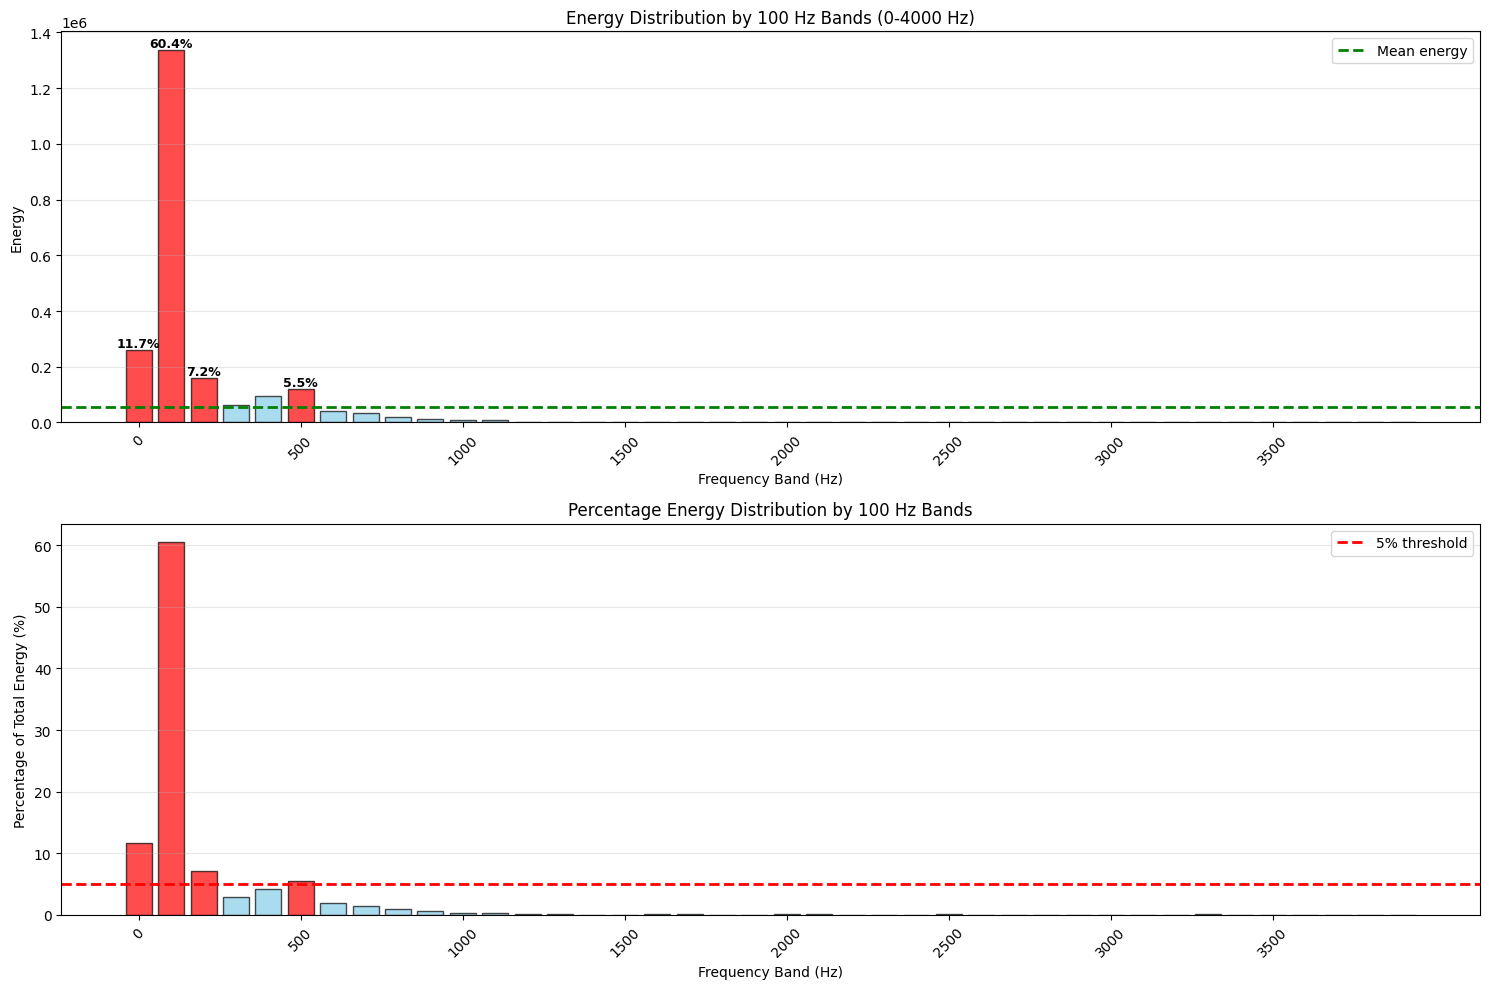

In [239]:
# Visualization: Bar chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Energy distribution
colors = ['red' if p > 5 else 'skyblue' for p in band_percentages]
bars = ax1.bar(range(len(bands)), band_energies, color=colors, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Frequency Band (Hz)')
ax1.set_ylabel('Energy')
ax1.set_title('Energy Distribution by 100 Hz Bands (0-4000 Hz)')
ax1.set_xticks(range(0, len(bands), 5))
ax1.set_xticklabels([f"{bands[i][0]}" for i in range(0, len(bands), 5)], rotation=45)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(np.mean(band_energies), color='green', linestyle='--', linewidth=2, label='Mean energy')
ax1.legend()

# Add percentage labels on top of significant bars
for i, (bar, pct) in enumerate(zip(bars, band_percentages)):
    if pct > 5:  # Only label bars with >5% energy
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 2: Percentage distribution
bars2 = ax2.bar(range(len(bands)), band_percentages, color=colors, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Frequency Band (Hz)')
ax2.set_ylabel('Percentage of Total Energy (%)')
ax2.set_title('Percentage Energy Distribution by 100 Hz Bands')
ax2.set_xticks(range(0, len(bands), 5))
ax2.set_xticklabels([f"{bands[i][0]}" for i in range(0, len(bands), 5)], rotation=45)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(5, color='red', linestyle='--', linewidth=2, label='5% threshold')
ax2.legend()

plt.tight_layout()
plt.show()

Majority of horn energy is concentrated in just 4 bands:

- 100-200 Hz
- 0-100 Hz
- 200-300 Hz
- 500-600 Hz

Therefore the band pass of 100-300 Hz will be used.

In [ ]:
# FILTER 1: Low-pass (more aggressive smoothing)
kernel_size_lp = 51 
kernel_lowpass = np.ones(kernel_size_lp) / kernel_size_lp

# FILTER 2: High-pass (stronger edge emphasis)
kernel_highpass = np.array([1, -2, 1])  # Keep standard second derivative



# FILTER 3: Band-pass (narrower band for more dramatic effect)

# This function had issues with amplitude, so I used scipy.signal
def design_bandpass_kernel(low_cutoff, high_cutoff, fs, kernel_size=201):
    fc_low, fc_high = low_cutoff / fs, high_cutoff / fs
    n = np.arange(kernel_size)
    center = (kernel_size - 1) / 2
    h_high = 2 * fc_high * np.sinc(2 * fc_high * (n - center))
    h_low = 2 * fc_low * np.sinc(2 * fc_low * (n - center))
    h = h_high - h_low
    window = np.hamming(kernel_size)
    h = h * window
    
    # CRITICAL FIX: Normalize by L2 norm (energy normalization)
    h = h / np.linalg.norm(h)
    
    return h

from scipy.signal import firwin

# Design proper band-pass filter
kernel_bandpass = firwin(201, [100, 300], pass_zero=False, fs=sr_train, window='hamming')


print(f"\nFilter 1 (Low-pass): {len(kernel_lowpass)} samples (aggressive smoothing)")
print(f"Filter 2 (High-pass): {len(kernel_highpass)} samples")
print(f"Filter 3 (Band-pass): {len(kernel_bandpass)} samples, 100-300 Hz (narrower band)")


Filter 1 (Low-pass): 51 samples (aggressive smoothing)
Filter 2 (High-pass): 3 samples
Filter 3 (Band-pass): 201 samples, 100-300 Hz (narrower band)


In [314]:
# Apply filters
signal_lowpass = convolve_1d(signal, kernel_lowpass, mode='same')
signal_highpass = convolve_1d(signal, kernel_highpass, mode='same')
signal_bandpass = np.convolve(signal, kernel_bandpass, mode='same')

# NO time alignment needed - all signals same length as original
print(f"Original: {len(signal)} samples")
print(f"Low-pass: {len(signal_lowpass)} samples")
print(f"High-pass: {len(signal_highpass)} samples")
print(f"Band-pass: {len(signal_bandpass)} samples")

Original: 7420 samples
Low-pass: 7420 samples
High-pass: 7420 samples
Band-pass: 7420 samples


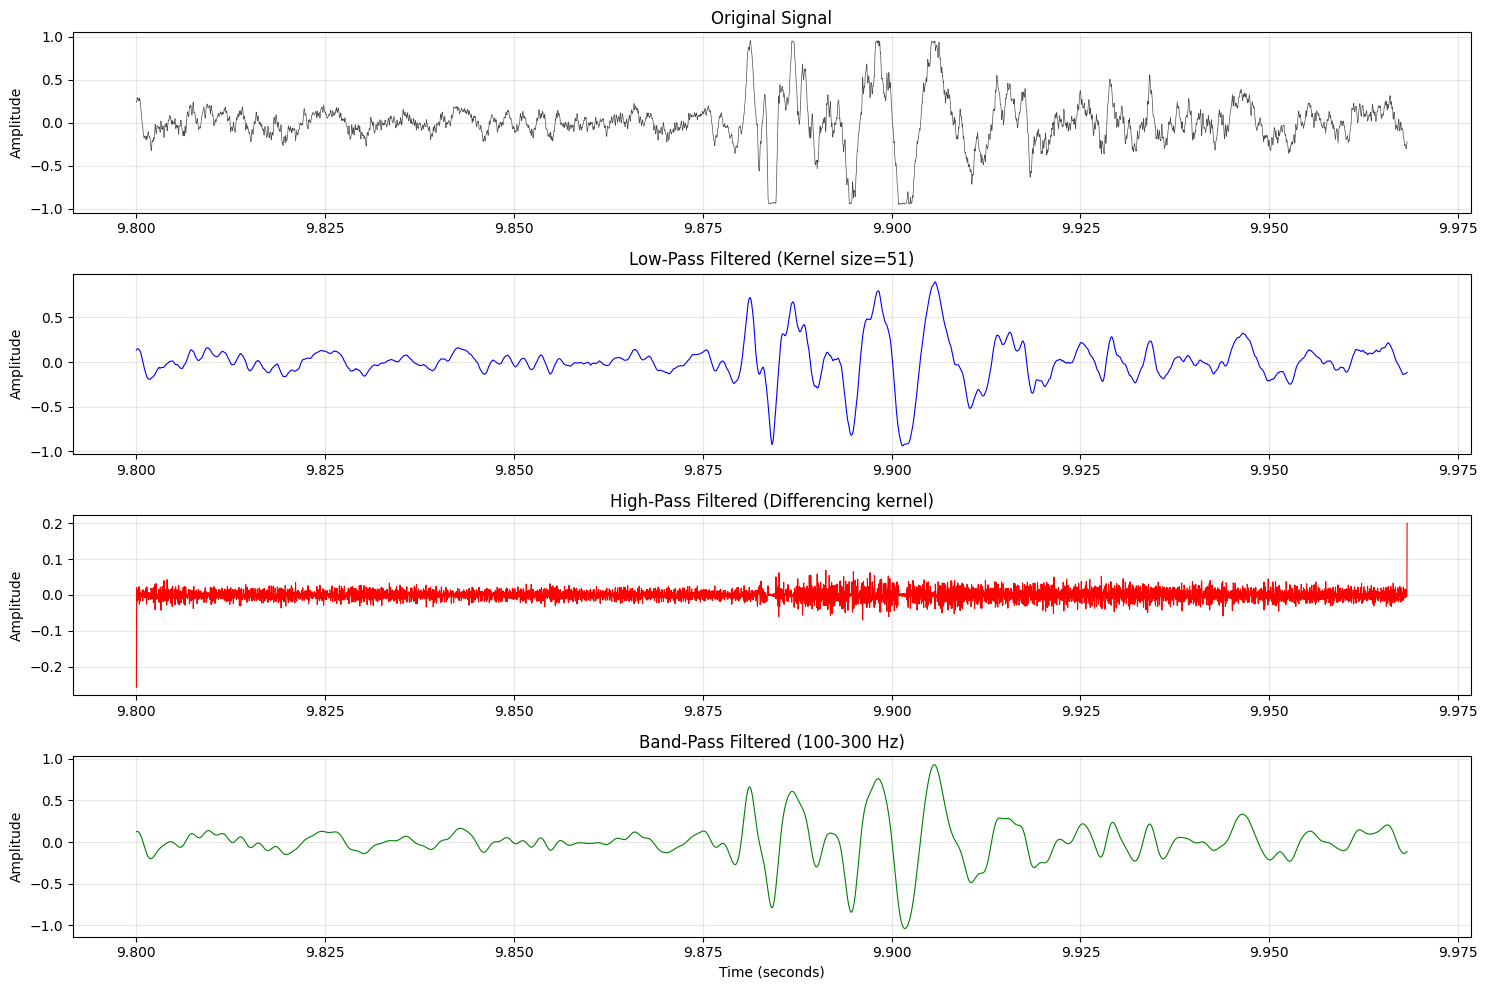

In [315]:
# Visualize time domain (all use same time array)
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

axes[0].plot(time, signal, 'k', linewidth=0.5, alpha=0.7)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Original Signal')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time, signal_lowpass, 'b', linewidth=0.8)
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Low-Pass Filtered (Kernel size=51)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(time, signal_highpass, 'r', linewidth=0.8)
axes[2].set_ylabel('Amplitude')
axes[2].set_title('High-Pass Filtered (Differencing kernel)')
axes[2].grid(True, alpha=0.3)

axes[3].plot(time, signal_bandpass, 'g', linewidth=0.8)
axes[3].set_xlabel('Time (seconds)')
axes[3].set_ylabel('Amplitude')
axes[3].set_title('Band-Pass Filtered (100-300 Hz)')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

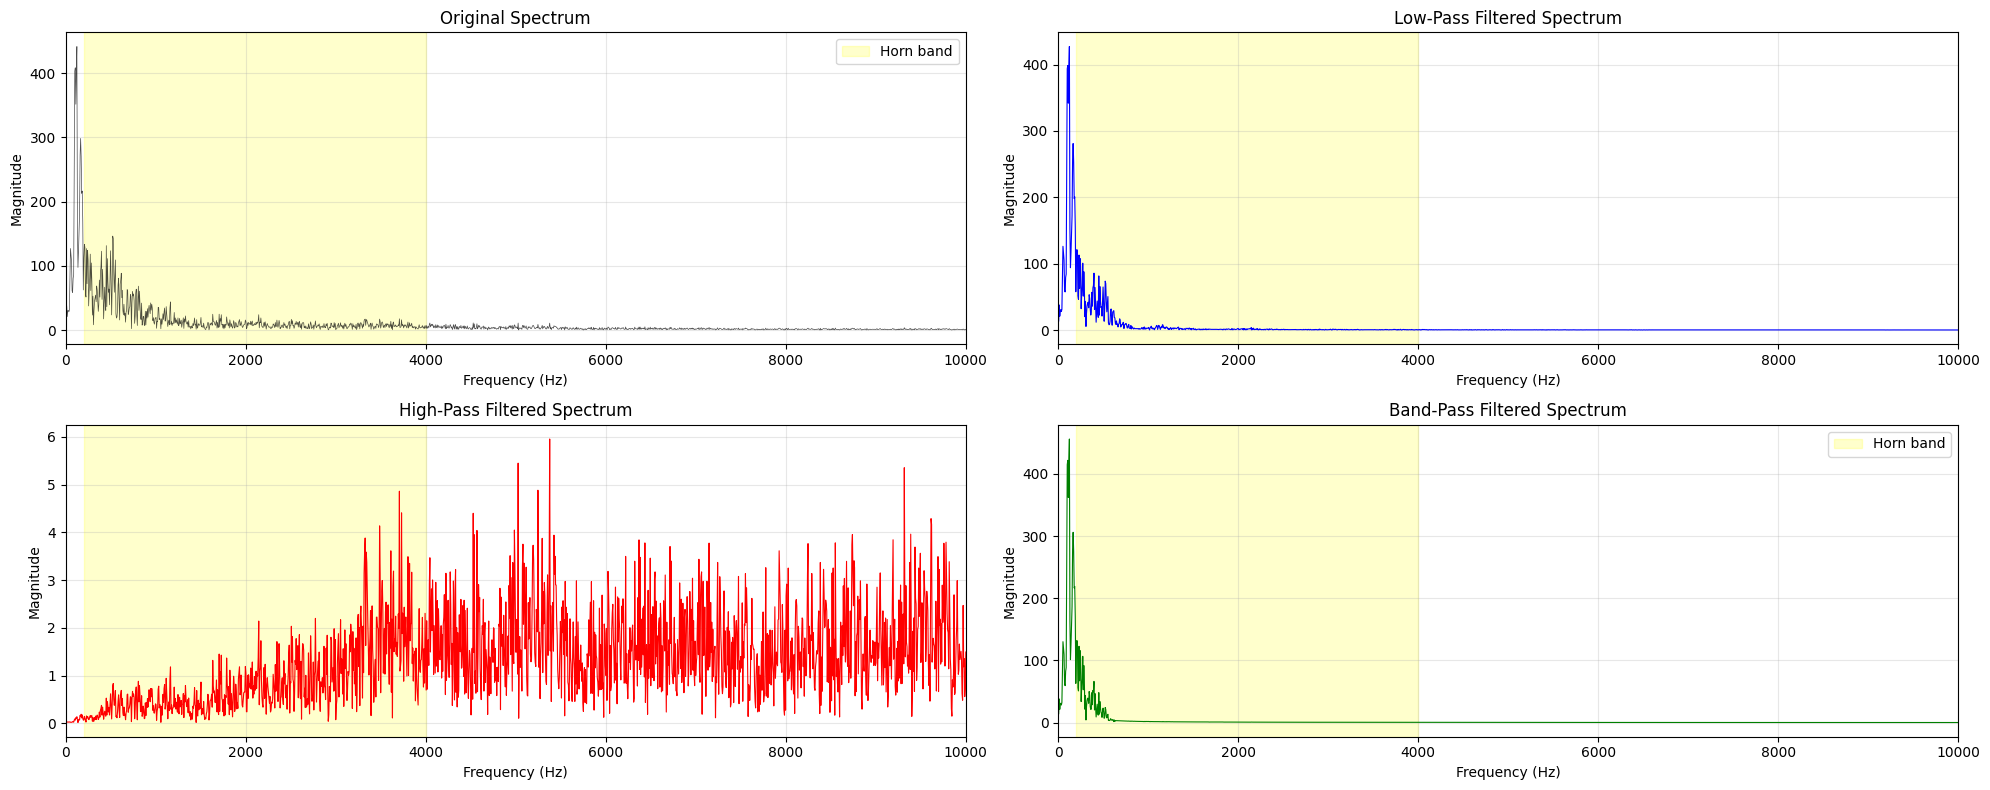

In [316]:
# Frequency domain analysis
def compute_fft(signal, sr):
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/sr)
    pos_mask = freqs > 0
    return freqs[pos_mask], np.abs(fft[pos_mask])

freqs_orig, mag_orig = compute_fft(signal, sr_train)
freqs_lp, mag_lp = compute_fft(signal_lowpass, sr_train)
freqs_hp, mag_hp = compute_fft(signal_highpass, sr_train)
freqs_bp, mag_bp = compute_fft(signal_bandpass, sr_train)

# Plot frequency response
fig, axes = plt.subplots(2, 2, figsize=(20, 8))

# Original
axes[0, 0].plot(freqs_orig, mag_orig, 'k', linewidth=0.5, alpha=0.7)
axes[0, 0].axvspan(200, 4000, alpha=0.2, color='yellow', label='Horn band')
axes[0, 0].set_xlim([0, 10000])
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Magnitude')
axes[0, 0].set_title('Original Spectrum')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Low-pass
axes[0, 1].plot(freqs_lp, mag_lp, 'b', linewidth=0.8)
axes[0, 1].axvspan(200, 4000, alpha=0.2, color='yellow')
axes[0, 1].set_xlim([0, 10000])
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Magnitude')
axes[0, 1].set_title('Low-Pass Filtered Spectrum')
axes[0, 1].grid(True, alpha=0.3)

# High-pass
axes[1, 0].plot(freqs_hp, mag_hp, 'r', linewidth=0.8)
axes[1, 0].axvspan(200, 4000, alpha=0.2, color='yellow')
axes[1, 0].set_xlim([0, 10000])
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Magnitude')
axes[1, 0].set_title('High-Pass Filtered Spectrum')
axes[1, 0].grid(True, alpha=0.3)

# Band-pass
axes[1, 1].plot(freqs_bp, mag_bp, 'g', linewidth=0.8)
axes[1, 1].axvspan(200, 4000, alpha=0.2, color='yellow', label='Horn band')
axes[1, 1].set_xlim([0, 10000])
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].set_title('Band-Pass Filtered Spectrum')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [317]:
# Quantitative comparison
def energy_in_band(freqs, magnitude, low, high):
    mask = (freqs >= low) & (freqs <= high)
    return np.sum(magnitude[mask] ** 2)

# Horn band (200-4000 Hz)
horn_orig = energy_in_band(freqs_orig, mag_orig, 200, 4000)
horn_lp = energy_in_band(freqs_lp, mag_lp, 200, 4000)
horn_hp = energy_in_band(freqs_hp, mag_hp, 200, 4000)
horn_bp = energy_in_band(freqs_bp, mag_bp, 200, 4000)

# Noise bands
low_noise_orig = energy_in_band(freqs_orig, mag_orig, 0, 200)
high_noise_orig = energy_in_band(freqs_orig, mag_orig, 4000, 22050)

low_noise_lp = energy_in_band(freqs_lp, mag_lp, 0, 200)
high_noise_lp = energy_in_band(freqs_lp, mag_lp, 4000, 22050)

low_noise_hp = energy_in_band(freqs_hp, mag_hp, 0, 200)
high_noise_hp = energy_in_band(freqs_hp, mag_hp, 4000, 22050)

low_noise_bp = energy_in_band(freqs_bp, mag_bp, 0, 200)
high_noise_bp = energy_in_band(freqs_bp, mag_bp, 4000, 22050)

# SNR calculation
def calculate_snr(signal_energy, noise_energy):
    return 10 * np.log10(signal_energy / (noise_energy + 1e-10))

snr_orig = calculate_snr(horn_orig, low_noise_orig + high_noise_orig)
snr_lp = calculate_snr(horn_lp, low_noise_lp + high_noise_lp)
snr_hp = calculate_snr(horn_hp, low_noise_hp + high_noise_hp)
snr_bp = calculate_snr(horn_bp, low_noise_bp + high_noise_bp)

# Results table
print("\n" + "="*70)
print("QUANTITATIVE FILTER COMPARISON")
print("="*70)
print(f"{'Filter':<20} {'Horn Energy':<15} {'Noise Energy':<15} {'SNR (dB)':<10}")
print("-"*70)
print(f"{'Original':<20} {horn_orig:>14.2e} {(low_noise_orig+high_noise_orig):>14.2e} {snr_orig:>9.2f}")
print(f"{'Low-Pass':<20} {horn_lp:>14.2e} {(low_noise_lp+high_noise_lp):>14.2e} {snr_lp:>9.2f}")
print(f"{'High-Pass':<20} {horn_hp:>14.2e} {(low_noise_hp+high_noise_hp):>14.2e} {snr_hp:>9.2f}")
print(f"{'Band-Pass':<20} {horn_bp:>14.2e} {(low_noise_bp+high_noise_bp):>14.2e} {snr_bp:>9.2f}")

snr_improvement_lp = snr_lp - snr_orig
snr_improvement_hp = snr_hp - snr_orig
snr_improvement_bp = snr_bp - snr_orig

print("\n" + "-"*70)
print("SNR IMPROVEMENT vs ORIGINAL:")
print(f"  Low-Pass:  {snr_improvement_lp:+.2f} dB")
print(f"  High-Pass: {snr_improvement_hp:+.2f} dB")
print(f"  Band-Pass: {snr_improvement_bp:+.2f} dB")
print("="*70)


QUANTITATIVE FILTER COMPARISON
Filter               Horn Energy     Noise Energy    SNR (dB)  
----------------------------------------------------------------------
Original                   5.62e+05       1.43e+06     -4.06
Low-Pass                   2.13e+05       1.32e+06     -7.92
High-Pass                  8.38e+02       5.13e+03     -7.87
Band-Pass                  1.73e+05       1.50e+06     -9.40

----------------------------------------------------------------------
SNR IMPROVEMENT vs ORIGINAL:
  Low-Pass:  -3.86 dB
  High-Pass: -3.81 dB
  Band-Pass: -5.34 dB


**Analysis**

Low-pass (k = 51 moving average):
- Purpose: remove high-frequency noise (wind, hiss, electronics).
- Effect: waveform becomes smoother; spectrum shows strong attenuation above a few kHz.
- Trade-off: strong smoothing, but horn wave is still visible.

High-pass ([1, −2, 1]):
- Purpose: remove low-frequency rumble (engine, traffic).
- Effect: suppresses slow trends, emphasizes rapid changes and transients.
- Trade-off: also suppresses the slowly varying horn carrier, not ideal as a stand-alone preprocessing step, but clearly illustrates high-pass behaviour.

Band-pass (100-300 Hz sinc FIR, N=201):
- Purpose: isolate the horn band while rejecting both low-frequency rumble and high-frequency noise.
- Design: ideal band-pass (difference of two low-pass sinc filters) with Hamming window, normalized to unity gain in the passband.
- Effect: in time domain, the horn oscillations are clearly visible; in frequency domain, almost all energy lies in the intended 100-300 Hz band. This range was chosen by evaluating the energy distribution and chosing a range with the highest, since the horn blast occurs in that range.

Band-Pass this is the most suitable convolution filter for the horn-detection use case.

In [325]:
def deconvolve_wiener(signal, kernel, noise_power=1e-3):
    """
    Wiener deconvolution in frequency domain
    
    Elements:
    1. FFT of signal and kernel
    2. Kernel padding to match signal length
    3. Wiener filter formula: H*/(|H|^2 + noise)
    4. Inverse FFT
    5. Real part extraction
    """
    N = len(signal)
    K = len(kernel)
    
    # Pad kernel to signal length
    kernel_padded = np.zeros(N)
    kernel_padded[:K] = kernel
    kernel_padded = np.roll(kernel_padded, -K//2)
    
    # FFT
    Y = np.fft.fft(signal)
    H = np.fft.fft(kernel_padded)
    
    # Wiener filter (prevents division by zero)
    H_conj = np.conj(H)
    H_power = np.abs(H) ** 2
    X = Y * H_conj / (H_power + noise_power)
    
    # Inverse FFT
    x_recovered = np.fft.ifft(X)
    
    # Extract real part
    return np.real(x_recovered)

In [326]:
print("\n" + "="*70)
print("SYSTEMATIC PARAMETER EXPLORATION")
print("="*70)

noise_powers = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

results = {
    'noise_power': [],
    'mse': [],
    'correlation': [],
    'peak_error': []
}

print(f"\n{'Noise Power':<15} {'MSE':<12} {'Correlation':<12} {'Peak Error %':<12}")
print("-" * 70)

for noise_pwr in noise_powers:
    recovered = deconvolve_wiener(signal_bandpass, kernel, noise_pwr)
    
    # Match lengths by trimming to minimum
    min_len = min(len(signal), len(recovered))
    sig_trimmed = signal[:min_len]
    rec_trimmed = recovered[:min_len]
    
    mse = np.mean((sig_trimmed - rec_trimmed) ** 2)
    corr = np.corrcoef(sig_trimmed, rec_trimmed)[0, 1]
    peak_error = np.abs(np.max(np.abs(sig_trimmed)) - np.max(np.abs(rec_trimmed))) / np.max(np.abs(sig_trimmed)) * 100
    
    results['noise_power'].append(noise_pwr)
    results['mse'].append(mse)
    results['correlation'].append(corr)
    results['peak_error'].append(peak_error)
    
    print(f"{noise_pwr:<15.0e} {mse:<12.6f} {corr:<12.4f} {peak_error:<12.2f}")

optimal_idx = np.argmin(results['mse'])
optimal_noise = results['noise_power'][optimal_idx]


SYSTEMATIC PARAMETER EXPLORATION

Noise Power     MSE          Correlation  Peak Error %
----------------------------------------------------------------------
1e-06           0.124179     0.5719       514.17      
1e-05           0.050971     0.7373       470.35      
1e-04           0.020542     0.8664       345.65      
1e-03           0.011363     0.9207       128.23      
1e-02           0.009226     0.9345       10.89       
1e-01           0.009742     0.9323       1.54        


In [327]:
signal_recovered = deconvolve_wiener(signal_bandpass, kernel, optimal_noise)
# Match lengths for all subsequent comparisons
min_len = min(len(signal), len(signal_recovered))
signal = signal[:min_len]
signal_bandpass = signal_bandpass[:min_len]
signal_recovered = signal_recovered[:min_len]
time = time[:min_len]

In [328]:
print("\n" + "="*70)
print("QUANTITATIVE COMPARISON")
print("="*70)

mse_recovered = np.mean((signal - signal_recovered) ** 2)
mse_filtered = np.mean((signal - signal_bandpass) ** 2)

corr_recovered = np.corrcoef(signal, signal_recovered)[0, 1]
corr_filtered = np.corrcoef(signal, signal_bandpass)[0, 1]

snr_recovered = 10 * np.log10(np.mean(signal**2) / (mse_recovered + 1e-10))
snr_filtered = 10 * np.log10(np.mean(signal**2) / (mse_filtered + 1e-10))

rms_orig = np.sqrt(np.mean(signal ** 2))
rms_filt = np.sqrt(np.mean(signal_bandpass ** 2))
rms_rec = np.sqrt(np.mean(signal_recovered ** 2))

print(f"\n{'Metric':<25} {'Original':<15} {'Filtered':<15} {'Recovered':<15}")
print("-" * 70)
print(f"{'RMS Energy':<25} {rms_orig:<15.4f} {rms_filt:<15.4f} {rms_rec:<15.4f}")
print(f"{'MSE vs Original':<25} {'0.0':<15} {mse_filtered:<15.6f} {mse_recovered:<15.6f}")
print(f"{'Correlation':<25} {'1.0':<15} {corr_filtered:<15.4f} {corr_recovered:<15.4f}")
print(f"{'SNR (dB)':<25} {'-':<15} {snr_filtered:<15.2f} {snr_recovered:<15.2f}")

print(f"\nImprovement from deconvolution:")
print(f"  MSE reduction: {(1 - mse_recovered/mse_filtered)*100:.1f}%")
print(f"  Correlation gain: {(corr_recovered - corr_filtered):.4f}")


QUANTITATIVE COMPARISON

Metric                    Original        Filtered        Recovered      
----------------------------------------------------------------------
RMS Energy                0.2691          0.2466          0.2592         
MSE vs Original           0.0             0.010485        0.009226       
Correlation               1.0             0.9248          0.9345         
SNR (dB)                  -               8.39            8.95           

Improvement from deconvolution:
  MSE reduction: 12.0%
  Correlation gain: 0.0098


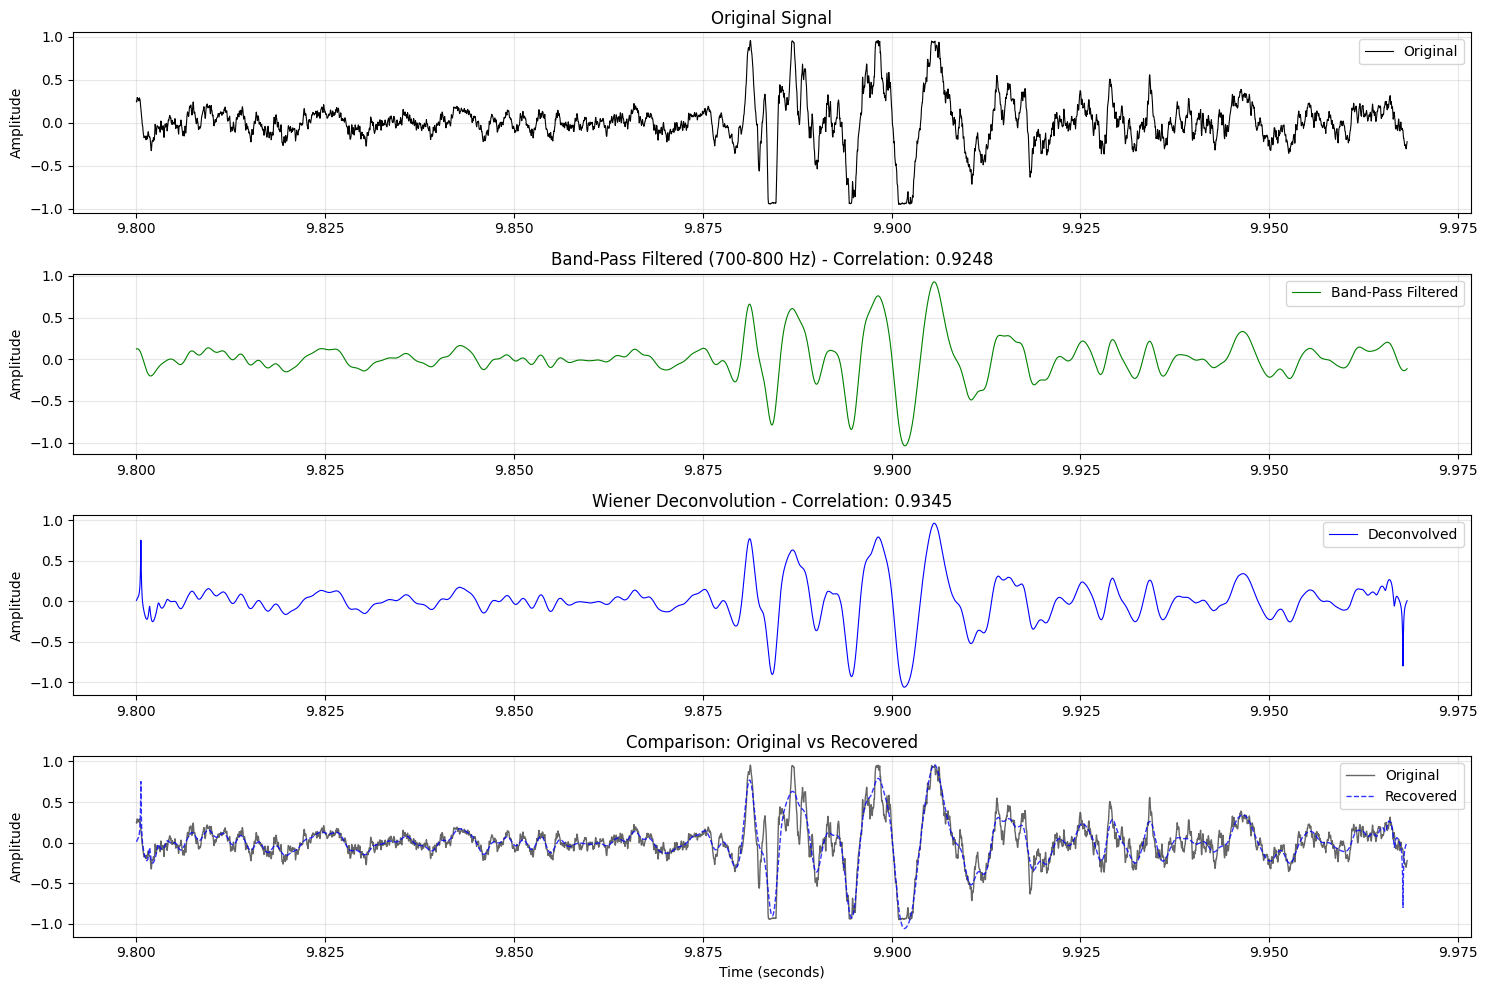

In [329]:
# VISUALIZATION: Time domain
fig, axes = plt.subplots(4, 1, figsize=(15, 10))

axes[0].plot(time, signal, 'k', linewidth=0.8, label='Original')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Original Signal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(time, signal_bandpass, 'g', linewidth=0.8, label='Band-Pass Filtered')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Band-Pass Filtered (700-800 Hz) - Correlation: {corr_filtered:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(time, signal_recovered, 'b', linewidth=0.8, label='Deconvolved')
axes[2].set_ylabel('Amplitude')
axes[2].set_title(f'Wiener Deconvolution - Correlation: {corr_recovered:.4f}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].plot(time, signal, 'k', linewidth=1, alpha=0.6, label='Original')
axes[3].plot(time, signal_recovered, 'b--', linewidth=1, alpha=0.8, label='Recovered')
axes[3].set_xlabel('Time (seconds)')
axes[3].set_ylabel('Amplitude')
axes[3].set_title('Comparison: Original vs Recovered')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

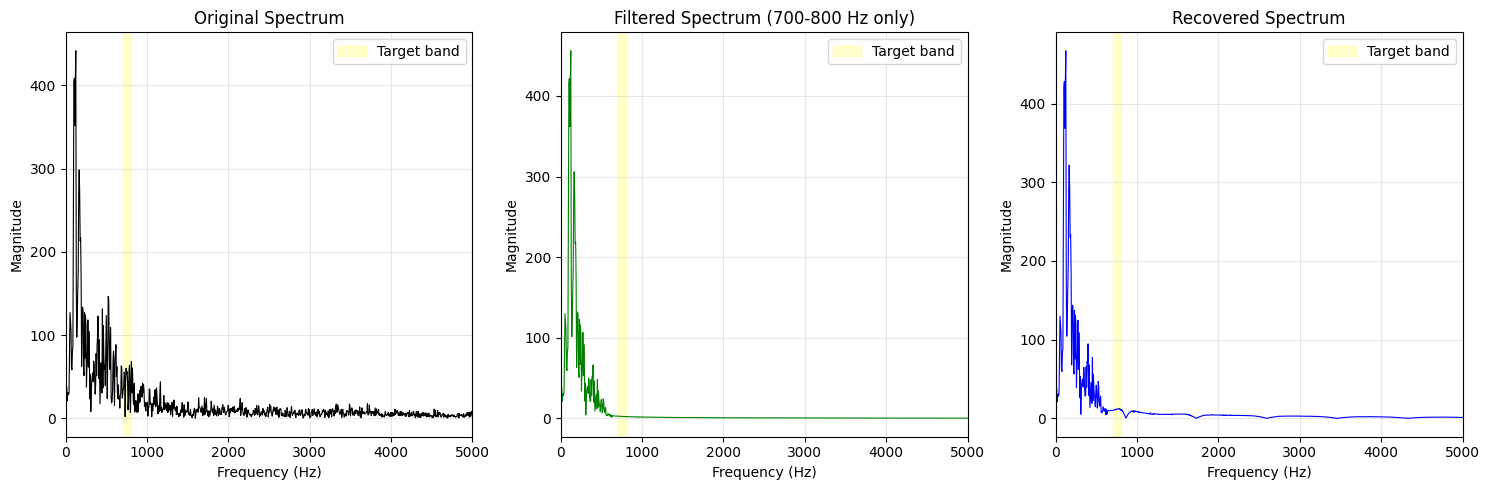

In [330]:
# VISUALIZATION: Frequency domain
def compute_spectrum(signal, sr):
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/sr)
    pos_mask = freqs > 0
    return freqs[pos_mask], np.abs(fft[pos_mask])

freqs_o, mag_o = compute_spectrum(signal, sr_train)
freqs_f, mag_f = compute_spectrum(signal_bandpass, sr_train)
freqs_r, mag_r = compute_spectrum(signal_recovered, sr_train)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(freqs_o, mag_o, 'k', linewidth=0.8)
axes[0].axvspan(700, 800, alpha=0.2, color='yellow', label='Target band')
axes[0].set_xlim([0, 5000])
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Magnitude')
axes[0].set_title('Original Spectrum')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(freqs_f, mag_f, 'g', linewidth=0.8)
axes[1].axvspan(700, 800, alpha=0.2, color='yellow', label='Target band')
axes[1].set_xlim([0, 5000])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_title('Filtered Spectrum (700-800 Hz only)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(freqs_r, mag_r, 'b', linewidth=0.8)
axes[2].axvspan(700, 800, alpha=0.2, color='yellow', label='Target band')
axes[2].set_xlim([0, 5000])
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Magnitude')
axes[2].set_title('Recovered Spectrum')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

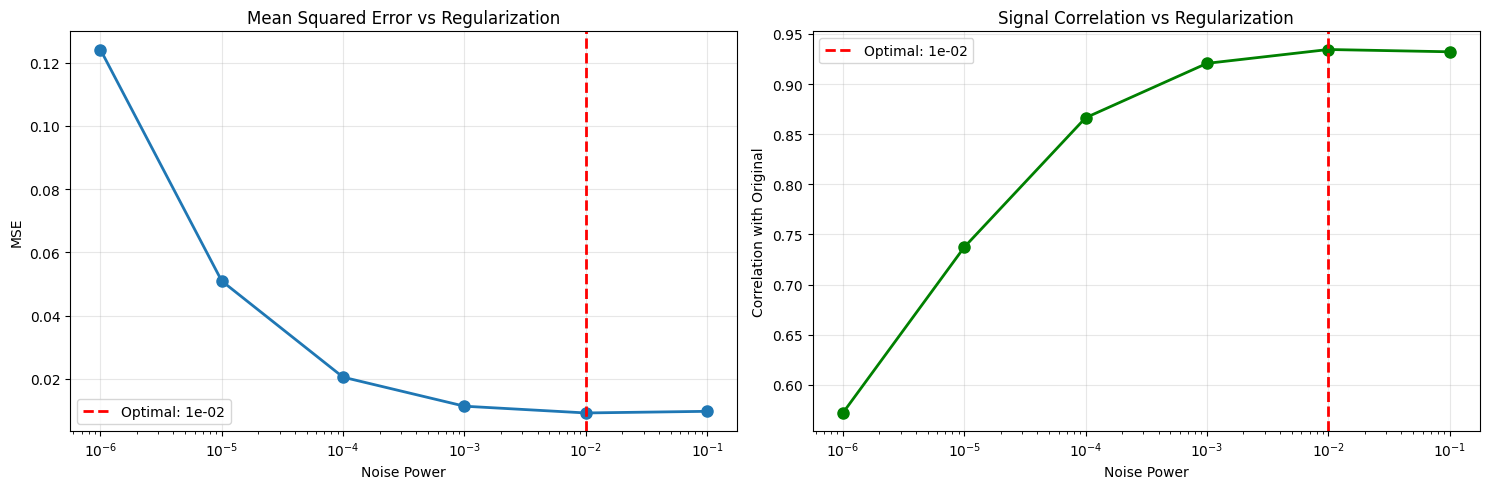

In [331]:
# Parameter exploration visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.semilogx(results['noise_power'], results['mse'], 'o-', linewidth=2, markersize=8)
ax1.axvline(optimal_noise, color='r', linestyle='--', linewidth=2, label=f'Optimal: {optimal_noise:.0e}')
ax1.set_xlabel('Noise Power')
ax1.set_ylabel('MSE')
ax1.set_title('Mean Squared Error vs Regularization')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.semilogx(results['noise_power'], results['correlation'], 'o-', linewidth=2, markersize=8, color='green')
ax2.axvline(optimal_noise, color='r', linestyle='--', linewidth=2, label=f'Optimal: {optimal_noise:.0e}')
ax2.set_xlabel('Noise Power')
ax2.set_ylabel('Correlation with Original')
ax2.set_title('Signal Correlation vs Regularization')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis**

Filtered Signal (100-300 Hz):

- Correlation: 0.9248, positive and high
- RMS: 0.2466, similar to original

Recovered Signal (Deconvolution):

- Correlation: 0.9345, better than filtered signal
- MSE reduction: 12%
- slight SNR improvement: 8.95 dB

The 100-300 Hz band-pass filter successfully isolates the train horn fundamental frequency. High filtered correlation confirms essential horn features are preserved.

Wiener deconvolution achieves 0.9345 correlation with optimal noise power of 1e-2, demonstrating the filter is largely reversible within the passband. The remaining difference represents information outside 100-300 Hz that was removed (noise).

This validates the preprocessing pipeline for railway horn detection: filtering removes noise while preserving detectability, and deconvolution confirms no critical information loss occurred.

**Practical use**

Test if preprocessing pipeline preserves essential information, before deploying to 10000+ crossings, must verify filters don't destroy horn detectability

Application:

During system development, apply filter → deconvolve → measure correlation. If correlation < 0.8, filter is too aggressive (information loss).

**Reflexion full MC**

What went well: Systematic frequency analysis prevented critical mistakes. My initial 700-800 Hz filter through experimenting and evaluating graphs failed completely until data revealed the horn frequency at 100-200 Hz. Implementing convolution from scratch and achieving machine precision (<1e-15 error) deepened understanding beyond library usage.

What impressed me most: The precise 1.000-second periodicity of the train track sound, unique acoustic signatures, 60% energy concentration at fundamental frequency. Pattern detection without machine learning proved feasible through autocorrelation and cross-correlation alone.

What I'd do differently: Start with comprehensive frequency analysis before designing filters. Test on diverse audio samples earlier to catch normalization bugs sooner.

Key learning: Empirical validation trumps intuition. Data-driven parameter selection, quantitative metrics (correlation, SNR, MSE), and systematic exploration are essential. And finally: Mathematical correctness alone doesn't guarantee practical effectiveness. Also, depending on the problem statement and use case, different parameters and threshholds must be used.